## 3.2 线性回归的从零开始实现

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归。在这一节中，我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集
为了简单起见，我们根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。我们将使用低维数据，这样可以很容易地将其可视化。在下面的代码中，我们生成了一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据是一个矩阵$X \in \mathbb R^{1000 \times 2}$

我们使用线性模型参数$w = [2, -3.4]^T、b=4.2$和噪声项$\epsilon$生成数据集及标签：

$$
y = Xw + b + \epsilon
$$

你可以将$\epsilon$视为模型预测和标签时的潜在观测误差。在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。为了简化问题，我们将标准差设为0.01。

In [2]:
def synthetic_data(w, b, num_examples): #@save
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值(一个标量)

In [4]:
print('features:', features[0], '\n label:', labels[0])

features: tensor([1.4951, 0.5532]) 
 label: tensor([5.2970])


通过生成第二个特征features[:, 1]和labels的散点图，可以直观观察到两者之间的线性关系 

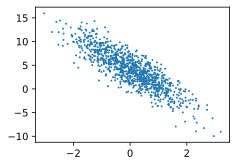

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
d2l.plt.show()

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量。每个小批量包含一组特征和标签。

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #这些样本是随机读取的，没有特定顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。每个样本都可以并行地进行计算，且每个样本损失函数的梯度也可以被并行计算。GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多

我们直观感受一下小批量：读取第一个小批量数据样本并打印。每个批量的特征维度显示批量大小和输入特征数。同样的，批量的标签形状与`batch_size`相等。

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.3597,  0.2031],
        [ 2.2077, -0.3627],
        [-0.2875,  0.9972],
        [-0.2975, -0.0517],
        [-0.1649, -1.1521],
        [ 2.1258,  1.2331],
        [-1.2336, -1.7586],
        [ 1.0979, -1.4316],
        [-0.8049,  0.4446],
        [ 1.5256,  1.1311]]) 
 tensor([[ 0.7803],
        [ 9.8395],
        [ 0.2335],
        [ 3.7972],
        [ 7.7899],
        [ 4.2772],
        [ 7.7132],
        [11.2677],
        [ 1.0655],
        [ 3.4259]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。


### 3.2.3 初始化模型参数
在我们开始小批量随机梯度下降优化我们的模型之前，我们需要先有一些参数。在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0.

In [20]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。因为手动计算梯度很枯燥且容易出错，所以没有人会手动计算梯度。

### 3.2.4 定义模型

接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。

In [12]:
def linreg(X, w, b): #@save
    return torch.matmul(X, w) + b

### 3.2.5 定义损失函数
因为需要计算损失函数的梯度，所以我们应该先定义损失函数。

In [13]:
def squared_loss(y_hat, y): #@save
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。下面的函数实现小批量速随机梯度下降。该函数接受模型参数集合、学习速率和批量大小作为输入。每一步更新的大小由学习率`lr`决定。因为我们计算的损失是一个批量样本的总和，所以我们用批量大小(batch_size)来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [14]:
def sgd(params, lr, batch_size): #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 训练
现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。在每一次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法sgd来更新模型参数。

概况一下，我们将执行以下循环：
- 初始化参数
- 重复以下训练，直到完成
    - 计算梯度$g \leftarrow \partial_{(w,b)} \frac{1}{\mid B\mid} \sum_{i \in B} l(x^{(i)}, y^{(i)}, w, b)$
    - 更新参数$(w,b) \leftarrow (w, b) - \eta g$

在每个迭代周期(epoch)中，我们使用`data_iter`函数遍历整个数据集，并将训练数据集中所有样本都使用一次(假设样本数能够被批量大小整除)。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。设置超参数很棘手，需要通过反复试验进行调整。

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [21]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.045295
epoch2, loss 0.000171
epoch3, loss 0.000048


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。因此，我们通过比较真实参数和通过训练学到的参数来评估训练的成功程度。

In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 9.7632e-05, -4.0507e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。在机器学习中，我们通常不太关心恢复真正的参数，而更关系如何高度准确预测参数。幸运的事，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。


### 3.2.8 小结
- 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
- 这一节只触及了表面知识。在下面的部分中，我们将基于刚刚介绍的概念模型描述其他模型，并学习如何更简洁地实现其他模型